In [1]:
import os
import sys
import yaml

import numpy as np
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)


In [2]:
target_dir = "./B/target/intermediates/"
shadow_dir = "./B/output/intermediates/"

no_shadows = 64
no_samples = 99

random_target = False


In [3]:
from sampling import load_results, bootstrap_sampling # hold_one_out_sampling


if random_target:
    target_logits, target_inmask, target_probs = None, None, None # sampler will intepret this as to randomize over 
    shadow_logits, shadow_inmask = load_results([target_dir+"/lira", shadow_dir+"/lira"], signal_name="rescaled_logits.npy")
    shadow_probs, _ = load_results([target_dir+"/rmia", shadow_dir+"/rmia"], signal_name="gtl_probabilities.npy")
    assert (_==shadow_inmask).all()
    print(shadow_logits.shape, shadow_probs.shape, shadow_inmask.shape)
else:
    target_logits, target_inmask = load_results(target_dir+"/lira", signal_name="rescaled_logits.npy")
    shadow_logits, shadow_inmask = load_results(shadow_dir+"/lira", signal_name="rescaled_logits.npy")
    target_probs, _ = load_results(target_dir+"/rmia", signal_name="gtl_probabilities.npy")
    assert (_==target_inmask).all()
    shadow_probs, _ = load_results(shadow_dir+"/rmia", signal_name="gtl_probabilities.npy")
    assert (_==shadow_inmask).all()
    print(target_logits.shape, target_probs.shape, target_inmask.shape)
    print(shadow_logits.shape, shadow_probs.shape, shadow_inmask.shape)



NOTE: all masks are unique as expected: 1 total
NOTE: all masks are unique as expected: 64 total
NOTE: all masks are unique as expected: 1 total
NOTE: all masks are unique as expected: 64 total
(60000, 1) (60000, 1) (60000, 1)
(60000, 64) (60000, 64) (60000, 64)


### Bootstrap sampling

Use bootstrap method to get many samples of ROC curve estimates. 

In [4]:
%%time

from leakpro.attacks.mia_attacks.lira import lira_vectorized

def lira_score_vectorized(target_signal, shadow_signal, shadow_inmask):
    return lira_vectorized(target_signal, shadow_signal, shadow_inmask, var_calculation = "individual_carlini")
    
lira_samples = bootstrap_sampling(no_shadows, no_samples, shadow_logits, shadow_inmask, target_logits, target_inmask, vec_mia_fun=lira_score_vectorized)  


CPU times: user 39.3 s, sys: 3.67 s, total: 43 s
Wall time: 43 s


In [5]:
%%time

from leakpro.attacks.mia_attacks.rmia import rmia_vectorised

def rmia_score_vectorized(target_signal, shadow_signal, shadow_inmask):
    return rmia_vectorised(target_signal, shadow_signal, shadow_inmask)

rmia_samples = bootstrap_sampling(no_shadows, no_samples, shadow_probs, shadow_inmask, target_probs, target_inmask, vec_mia_fun=rmia_score_vectorized)


CPU times: user 16.8 s, sys: 564 ms, total: 17.3 s
Wall time: 17.4 s


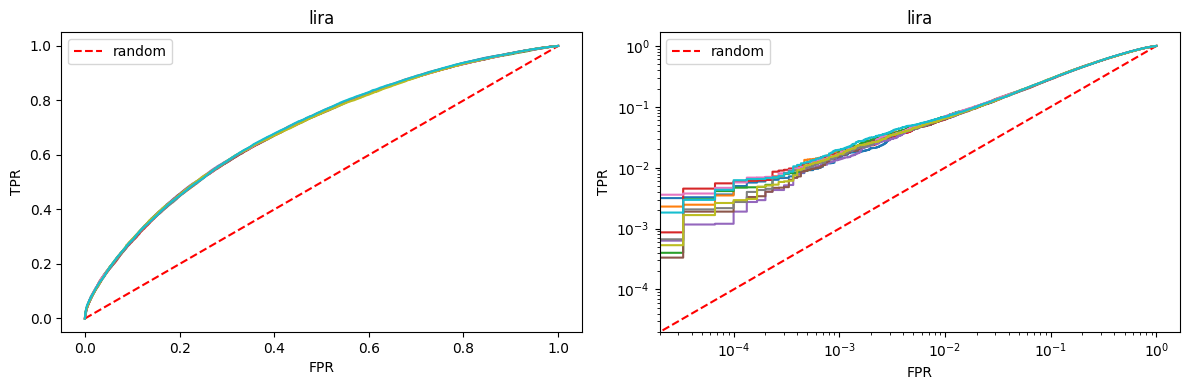

In [6]:
lira_unique_fpr = sorted(np.unique(np.concat([fpr for (fpr, tpr) in lira_samples])))

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(lira_unique_fpr, lira_unique_fpr, 'r--', label="random")
axs[1].loglog(lira_unique_fpr, lira_unique_fpr, 'r--', label="random")
for i in [0,1]:
    for (fpr, tpr) in lira_samples[:10]:
        axs[i].plot(fpr, tpr)
    axs[i].set_xlabel("FPR")
    axs[i].set_ylabel("TPR")
    axs[i].legend()
    axs[i].set_title("lira")
plt.tight_layout()
plt.show()


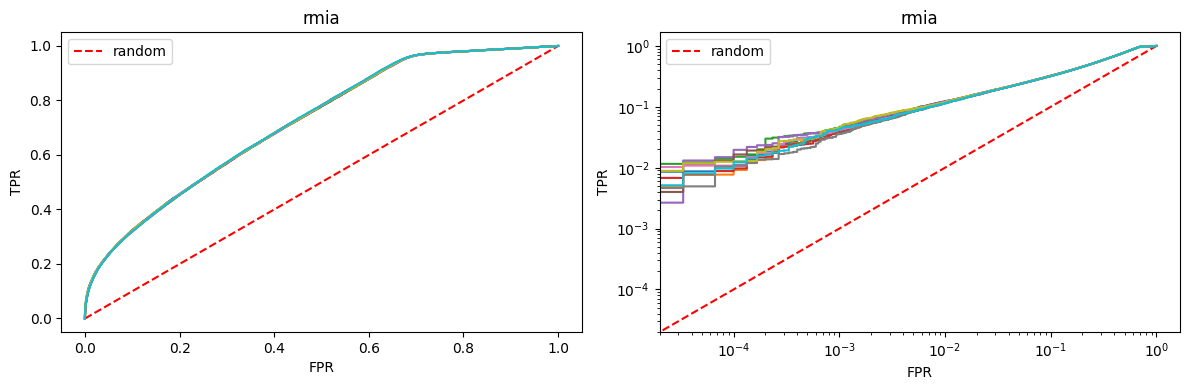

In [7]:
rmia_unique_fpr = sorted(np.unique(np.concat([fpr for (fpr, tpr) in rmia_samples])))

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(rmia_unique_fpr, rmia_unique_fpr, 'r--', label="random")
axs[1].loglog(rmia_unique_fpr, rmia_unique_fpr, 'r--', label="random")
for i in [0,1]:
    for (fpr, tpr) in rmia_samples[:10]:
        axs[i].plot(fpr, tpr)
    axs[i].set_xlabel("FPR")
    axs[i].set_ylabel("TPR")
    axs[i].legend()
    axs[i].set_title("rmia")
plt.tight_layout()
plt.show()


### Plot the average curve with confidence bands

The confidence bands are wider for small FPR. This is more visible in the log-log plot to the right. 

The default confidence is set at 95%. For higher confidence you may have to take more samples. 


In [8]:
from sampling import interpolate_unique

lira_interp_tpr = np.array([interpolate_unique(lira_unique_fpr, fpr, tpr) for (fpr, tpr) in lira_samples])
print(len(lira_unique_fpr), lira_interp_tpr.shape)

rmia_interp_tpr = np.array([interpolate_unique(rmia_unique_fpr, fpr, tpr) for (fpr, tpr) in rmia_samples])
print(len(rmia_unique_fpr), rmia_interp_tpr.shape)


30001 (99, 30001)
29980 (99, 29980)


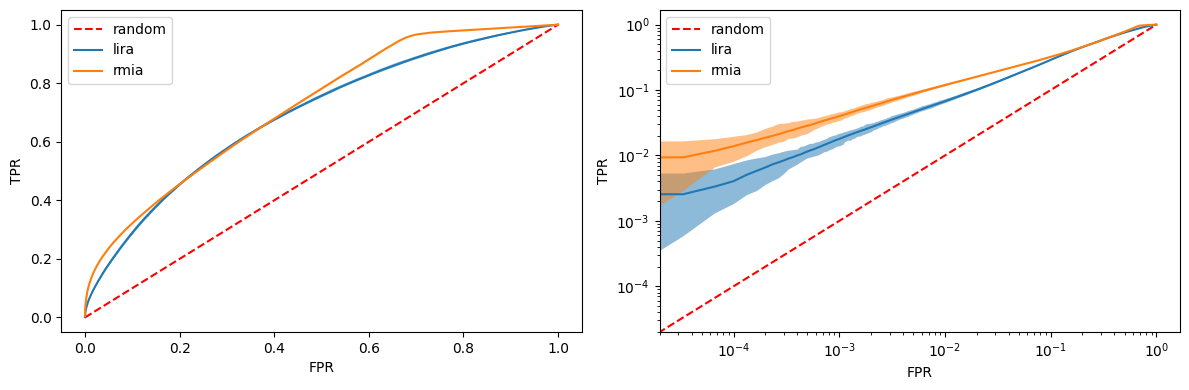

In [9]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(fpr, fpr, 'r--', label="random")
axs[1].loglog(fpr, fpr, 'r--', label="random")
for i in [0,1]:
    axs[i].plot(lira_unique_fpr,np.mean(lira_interp_tpr,axis=0),label="lira")
    axs[i].fill_between(lira_unique_fpr,np.percentile(lira_interp_tpr,2.5,axis=0),np.percentile(lira_interp_tpr,97.5,axis=0), alpha=0.5)
    axs[i].plot(rmia_unique_fpr,np.mean(rmia_interp_tpr,axis=0),label="rmia")
    axs[i].fill_between(rmia_unique_fpr,np.percentile(rmia_interp_tpr,2.5,axis=0),np.percentile(rmia_interp_tpr,97.5,axis=0), alpha=0.5)
    axs[i].set_xlabel("FPR")
    axs[i].set_ylabel("TPR")
    axs[i].legend()
plt.tight_layout()
plt.show()


### Plot histograms

Histograms of TPR for different FPR. 

Increase the no_samples to above 100 to get smoother historgrams.


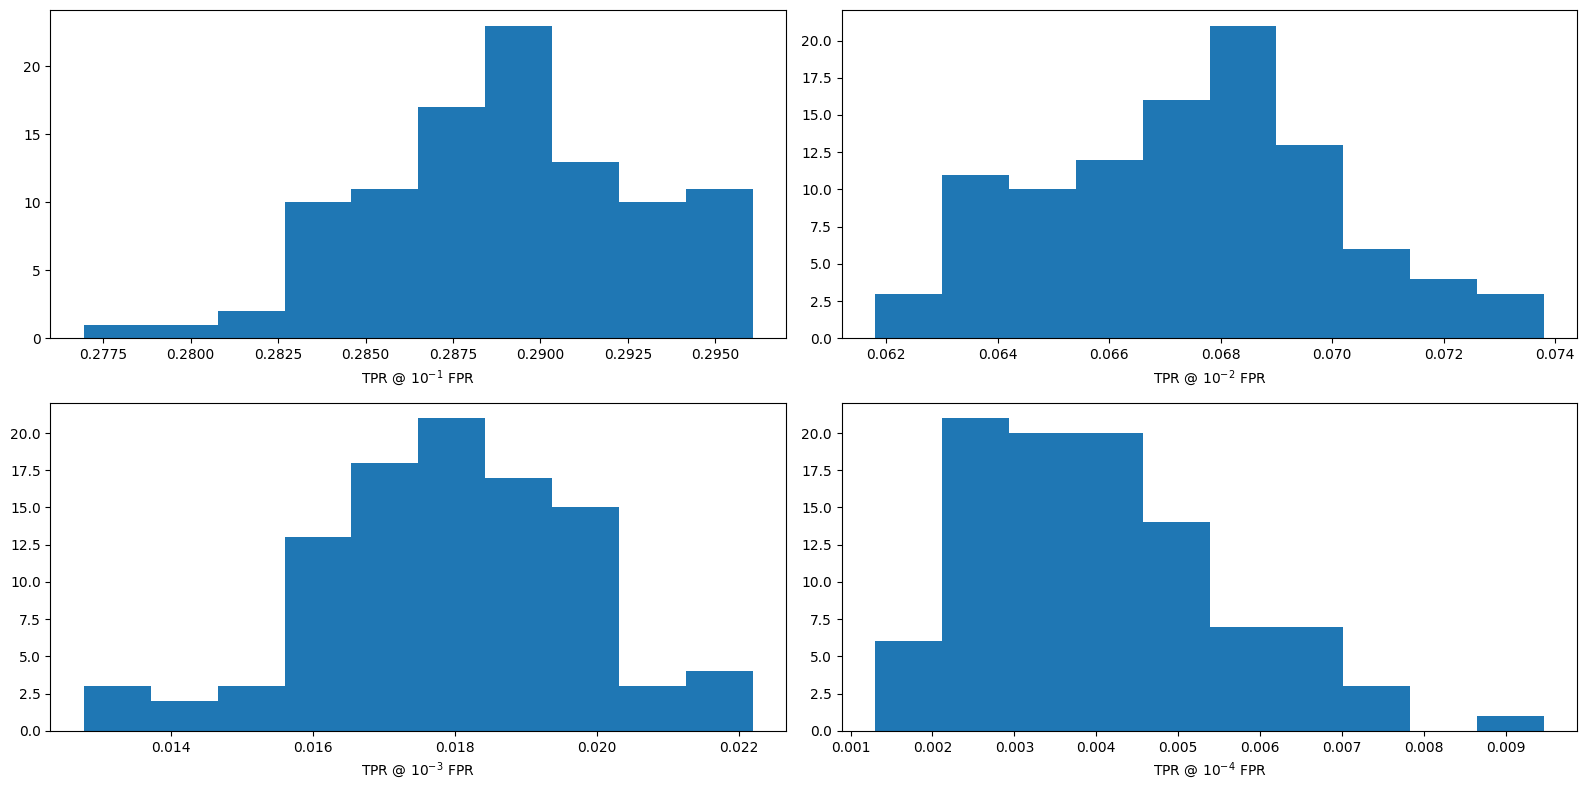

In [10]:
samples = lira_samples

fig, axs = plt.subplots(2,2, figsize=(16,8))
axs[0,0].hist([interpolate_unique(0.1,fpr,tpr) for (fpr,tpr) in samples], bins=10)
axs[0,1].hist([interpolate_unique(0.01,fpr,tpr) for (fpr,tpr) in samples], bins=10)
axs[1,0].hist([interpolate_unique(0.001,fpr,tpr) for (fpr,tpr) in samples], bins=10)
axs[1,1].hist([interpolate_unique(0.0001,fpr,tpr) for (fpr,tpr) in samples], bins=10)
axs[0,0].set_xlabel("TPR @ $10^{-1}$ FPR")
axs[0,1].set_xlabel("TPR @ $10^{-2}$ FPR")
axs[1,0].set_xlabel("TPR @ $10^{-3}$ FPR")
axs[1,1].set_xlabel("TPR @ $10^{-4}$ FPR")
plt.tight_layout()
plt.show()


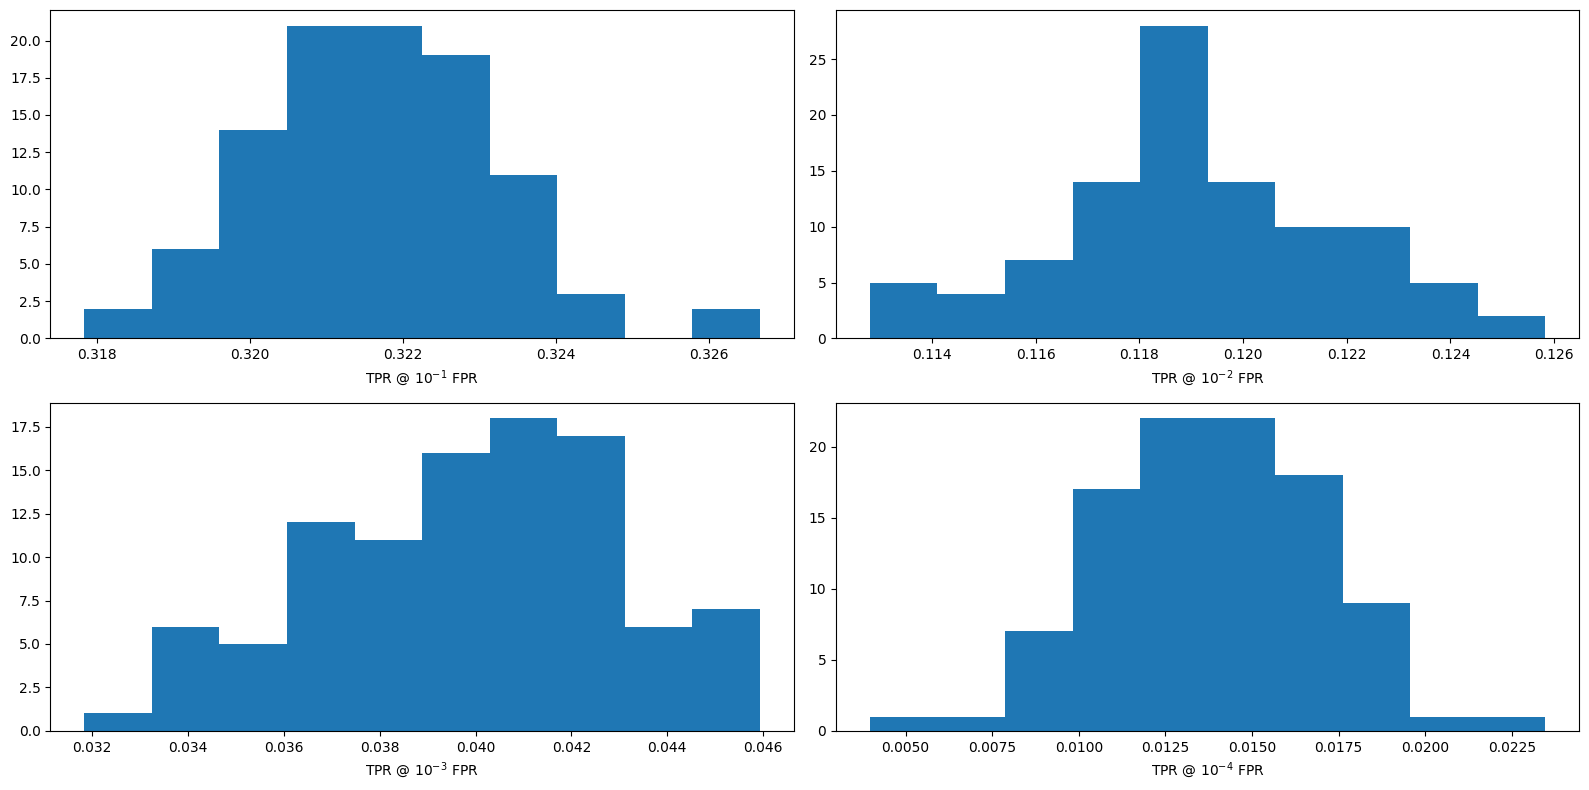

In [11]:
samples = rmia_samples

fig, axs = plt.subplots(2,2, figsize=(16,8))
axs[0,0].hist([interpolate_unique(0.1,fpr,tpr) for (fpr,tpr) in samples], bins=10)
axs[0,1].hist([interpolate_unique(0.01,fpr,tpr) for (fpr,tpr) in samples], bins=10)
axs[1,0].hist([interpolate_unique(0.001,fpr,tpr) for (fpr,tpr) in samples], bins=10)
axs[1,1].hist([interpolate_unique(0.0001,fpr,tpr) for (fpr,tpr) in samples], bins=10)
axs[0,0].set_xlabel("TPR @ $10^{-1}$ FPR")
axs[0,1].set_xlabel("TPR @ $10^{-2}$ FPR")
axs[1,0].set_xlabel("TPR @ $10^{-3}$ FPR")
axs[1,1].set_xlabel("TPR @ $10^{-4}$ FPR")
plt.tight_layout()
plt.show()


### Dependence on the number of shadow models

In this experiment we analyse how the estimted privacy risk metric varies with the number of available shadow models. 


In [12]:
lira_experiment = {
    no_shadows: lira_samples
}

for K in [4, 8, 16, 32, 48]:
    M = no_samples
    print(f"take {M} samples at {K} number of shadow models")
    lira_experiment[K] = bootstrap_sampling(K, M, shadow_logits, shadow_inmask, target_logits, target_inmask, vec_mia_fun=lira_score_vectorized)
    

take 99 samples at 4 number of shadow models


/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:282: RuntimeWarning: Mean of empty slice
  out_means = np.nanmean(np.where(~shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:283: RuntimeWarning: Mean of empty slice
  in_means = np.nanmean(np.where(shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:282: RuntimeWarning: Mean of empty slice
  out_means = np.nanmean(np.where(~shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:283: RuntimeWarning: Mean of empty slice
  in_means = np.nanmean(np.where(shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:282: RuntimeWarning: Mean of empty slice
  out_means = np.nanmean(np.where(~shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPr

take 99 samples at 8 number of shadow models


/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:282: RuntimeWarning: Mean of empty slice
  out_means = np.nanmean(np.where(~shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:283: RuntimeWarning: Mean of empty slice
  in_means = np.nanmean(np.where(shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:282: RuntimeWarning: Mean of empty slice
  out_means = np.nanmean(np.where(~shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:283: RuntimeWarning: Mean of empty slice
  in_means = np.nanmean(np.where(shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:282: RuntimeWarning: Mean of empty slice
  out_means = np.nanmean(np.where(~shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPr

take 99 samples at 16 number of shadow models


/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:282: RuntimeWarning: Mean of empty slice
  out_means = np.nanmean(np.where(~shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:283: RuntimeWarning: Mean of empty slice
  in_means = np.nanmean(np.where(shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:282: RuntimeWarning: Mean of empty slice
  out_means = np.nanmean(np.where(~shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:283: RuntimeWarning: Mean of empty slice
  in_means = np.nanmean(np.where(shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPro_robustness/leakpro/attacks/mia_attacks/lira.py:282: RuntimeWarning: Mean of empty slice
  out_means = np.nanmean(np.where(~shadow_inmask, shadow_logits, np.nan), axis=1)
/mnt/bigger/rbdev/LeakPr

take 99 samples at 32 number of shadow models
take 99 samples at 48 number of shadow models


In [13]:
rmia_experiment = {
    no_shadows: rmia_samples
}

for K in [4, 8, 16, 32, 48]:
    M = no_samples
    print(f"take {M} samples at {K} number of shadow models")
    rmia_experiment[K] = bootstrap_sampling(K, M, shadow_probs, shadow_inmask, target_probs, target_inmask, vec_mia_fun=rmia_score_vectorized)



take 99 samples at 4 number of shadow models
take 99 samples at 8 number of shadow models
take 99 samples at 16 number of shadow models
take 99 samples at 32 number of shadow models
take 99 samples at 48 number of shadow models


In [14]:
def stats(result, tail=0.01):
    temp = np.array([
        [interpolate_unique(tail,fpr,tpr) for (fpr, tpr) in result] 
            for tail in [0.1,0.01,0.001,0.0001]
    ])
    return temp.mean(axis=1), np.percentile(temp, 2.5, axis=1), np.percentile(temp, 97.5, axis=1)
    
np.array(stats(lira_experiment[no_shadows])).shape    


(3, 4)

In [15]:
lira_no_shadows_models = np.sort(list(lira_experiment.keys()))

lira_test = np.array([stats(lira_experiment[K]) for K in lira_no_shadows_models])


In [16]:
rmia_no_shadows_models = np.sort(list(rmia_experiment.keys()))

rmia_test = np.array([stats(rmia_experiment[K]) for K in rmia_no_shadows_models])


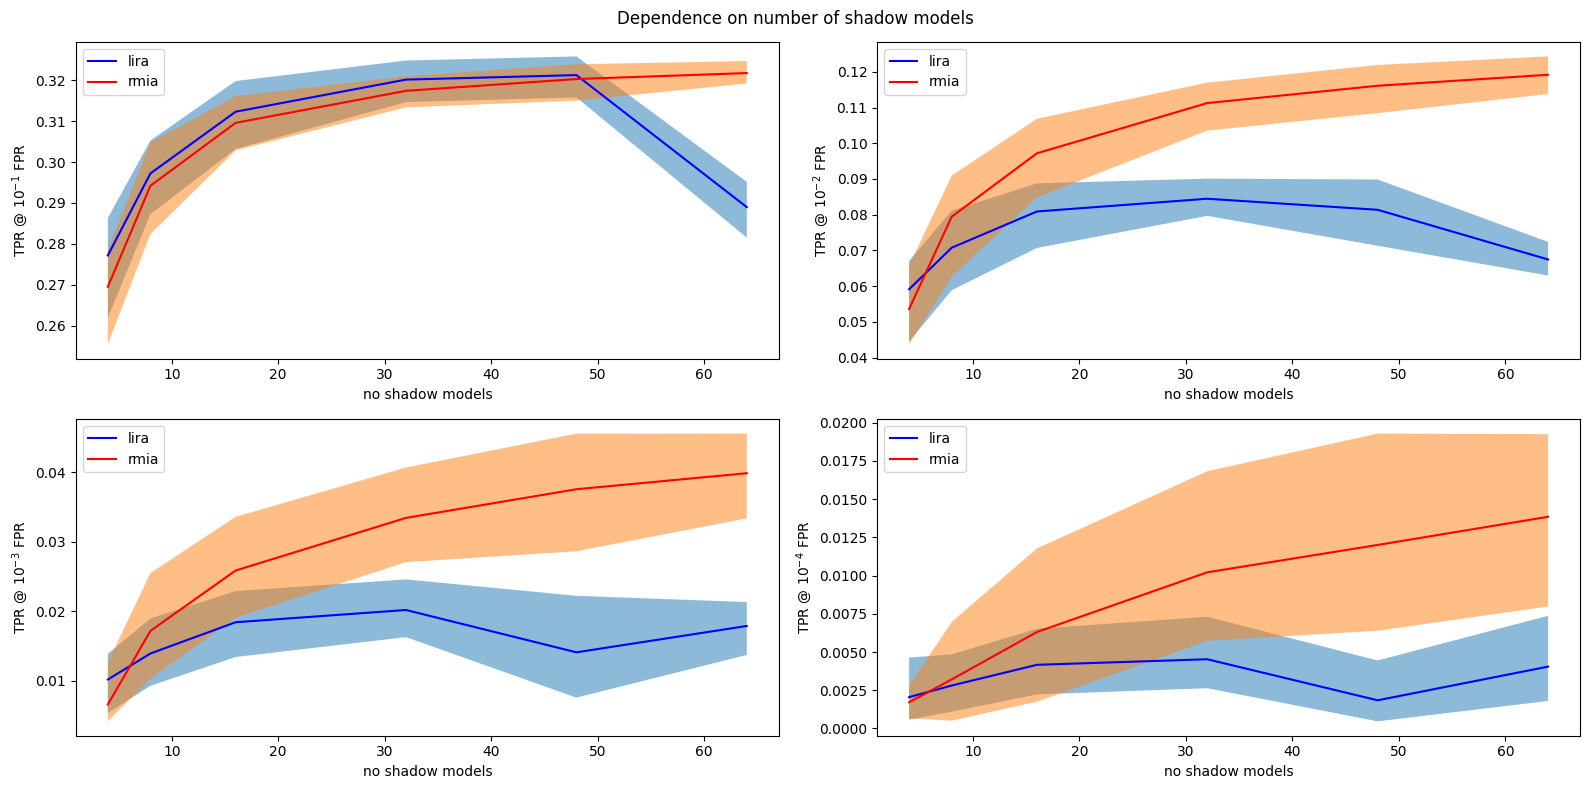

In [18]:
fig, axs = plt.subplots(2,2, figsize=(16,8))
for i in range(4):
    ax = axs[i//2,i%2]
    ax.plot(lira_no_shadows_models, lira_test[:,0,i],'b-',label="lira")
    ax.fill_between(lira_no_shadows_models, lira_test[:,1,i], lira_test[:,2,i], alpha=0.5)
    ax.plot(rmia_no_shadows_models, rmia_test[:,0,i],'r-',label="rmia")
    ax.fill_between(rmia_no_shadows_models, rmia_test[:,1,i], rmia_test[:,2,i], alpha=0.5)
    ax.set_ylabel("TPR @ $10^{"+f"{-1-i}"+"}$ FPR")
    ax.set_xlabel("no shadow models")
    ax.legend()
plt.suptitle("Dependence on number of shadow models")
plt.tight_layout()
plt.show()


3